# OverView

BaseModel:https://www.kaggle.com/khyeh0719/pytorch-efficientnet-baseline-train-amp-aug<br>
Inferece part: https://www.kaggle.com/khyeh0719/pytorch-efficientnet-baseline-inference-tta

confirm inferece:https://www.kaggle.com/harininarasimhan/why-not-to-trust-public-lb-visualization


In [1]:
package_paths = [
    '../input/pytorch-image-models-master', #'../input/efficientnet-pytorch-07/efficientnet_pytorch-0.7.0'
    '../input/FMix-master'
]
import sys; 

for pth in package_paths:
    sys.path.append(pth)
    
from fmix import sample_mask, make_low_freq_image, binarise_mask

In [2]:
from glob import glob
from sklearn.model_selection import GroupKFold, StratifiedKFold
import cv2
from skimage import io
import torch
from torch import nn
import os
from datetime import datetime
import time
import random
import cv2
import torchvision
from torchvision import transforms
import pandas as pd
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from torch.cuda.amp import autocast, GradScaler
from torch.nn.modules.loss import _WeightedLoss
import torch.nn.functional as F

import timm

import sklearn
import warnings
import joblib
from sklearn.metrics import roc_auc_score, log_loss
from sklearn import metrics
import warnings
import cv2
import pydicom
#from warmup_scheduler import GradualWarmupScheduler
#from efficientnet_pytorch import EfficientNet
from scipy.ndimage.interpolation import zoom
from catalyst.data.sampler import BalanceClassSampler
from albumentations import (
    HorizontalFlip, VerticalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine, RandomResizedCrop,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose, Normalize, Cutout, CoarseDropout, ShiftScaleRotate, CenterCrop, Resize
)
from albumentations.pytorch import ToTensorV2


Bad key "text.kerning_factor" on line 4 in
C:\Users\goomo\Anaconda3\envs\tf\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [3]:
CFG = {
    'input_path': '../input/cassava-leaf-disease-classification/',
    'weight_path': '../weight/',
    'version': 'v2',
    '2class_version': '2class_v1',
    'fold_num': 5,
    'seed': 2021,
    'model_arch': 'tf_efficientnet_b4_ns',
    'loss': 'Smoothed Cross Entropy Loss', # reference: https://www.kaggle.com/c/siim-isic-melanoma-classification/discussion/173733
    'optimizer': 'Adam',
    'scheduler': 'GradualWarmupScheduler',
    'img_size': 512,
    'epochs': 10,
    'train_bs': 16,
    'valid_bs': 32,
    'T_0': 10,
    'lr': 1e-4,
    'min_lr': 1e-6,
    'weight_decay': 1e-6,
    'num_workers': 0, # set 0 if windows 
    'accum_iter': 2, # suppoprt to do batch accumulation for backprop with effectively larger batch size
    'verbose_step': 1,
    'device': 'cuda:0',
    'warmup_factor': 10,
    'warmup_epo': 1,
    'tta': 3,
    'used_epochs': [16,17,18,19],
    'weights': [1,1,1,1],
    'used_2class':[6,7,8,9]
}

In [4]:
train = pd.read_csv(CFG['input_path'] + 'train.csv')
train.head()

image_id  label
0  1000015157.jpg      0
1  1000201771.jpg      3
2   100042118.jpg      1
3  1000723321.jpg      1
4  1000812911.jpg      3

In [5]:
train.label.value_counts()

3    13158
4     2577
2     2386
1     2189
0     1087
Name: label, dtype: int64

In [6]:
submission = pd.read_csv(CFG['input_path'] + 'sample_submission.csv')
submission.head()

image_id  label
0  2216849948.jpg      4

# Helper Functions

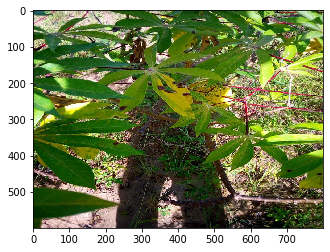

In [7]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
def get_img(path):
    im_bgr = cv2.imread(path)
    im_rgb = im_bgr[:, :, ::-1]
    #print(im_rgb)
    return im_rgb

img = get_img(CFG['input_path'] + 'train_images/1000015157.jpg')
plt.imshow(img)
plt.show()

# Dataset

In [8]:
def rand_bbox(size, lam):
    W = size[0]
    H = size[1]
    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)
    return bbx1, bby1, bbx2, bby2

In [9]:
class CassavaDataset(Dataset):
    def __init__(
        self, df, data_root, transforms=None, output_label=True
    ):
        
        super().__init__()
        self.df = df.reset_index(drop=True).copy()
        self.transforms = transforms
        self.data_root = data_root
        self.output_label = output_label
    
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, index: int):
        
        # get labels
        if self.output_label:
            target = self.df.iloc[index]['label']
          
        path = "{}/{}".format(self.data_root, self.df.iloc[index]['image_id'])
        
        img  = get_img(path)
        
        if self.transforms:
            img = self.transforms(image=img)['image']
            
        # do label smoothing
        if self.output_label == True:
            return img, target
        else:
            return img

# Define Train\Validation Image Augmentations

In [10]:
from albumentations import (
    HorizontalFlip, VerticalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine, RandomResizedCrop,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose, Normalize, Cutout, CoarseDropout, 
    ShiftScaleRotate, CenterCrop, Resize
)

from albumentations.pytorch import ToTensorV2

def get_inference_transforms():
    return Compose([
            RandomResizedCrop(CFG['img_size'], CFG['img_size']),
            Transpose(p=0.5),
            HorizontalFlip(p=0.5),
            VerticalFlip(p=0.5),
            HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
            RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
            ToTensorV2(p=1.0),
        ], p=1.)

# Model

In [11]:
class CassvaImgClassifier(nn.Module):
    def __init__(self, model_arch, n_class, pretrained=False):
        super().__init__()
        self.model = timm.create_model(model_arch, pretrained=pretrained)
        n_features = self.model.classifier.in_features
        self.model.classifier = nn.Linear(n_features, n_class)
        '''
        self.model.classifier = nn.Sequential(
            nn.Dropout(0.3),
            #nn.Linear(n_features, hidden_size,bias=True), nn.ELU(),
            nn.Linear(n_features, n_class, bias=True)
        )
        '''
    def forward(self, x):
        x = self.model(x)
        return x

# Main Loop

In [12]:
def inference_one_epoch(model, data_loader, device):
    model.eval()

    image_preds_all = []
    
    pbar = tqdm(enumerate(data_loader), total=len(data_loader))
    for step, (imgs) in pbar:
        imgs = imgs.to(device).float()
        
        image_preds = model(imgs)   #output = model(input)
        image_preds_all += [torch.softmax(image_preds, 1).detach().cpu().numpy()]
        
    
    image_preds_all = np.concatenate(image_preds_all, axis=0)
    return image_preds_all

In [14]:
if __name__ == '__main__':
     # for training only, need nightly build pytorch

    seed_everything(CFG['seed'])
    folds = StratifiedKFold(n_splits=CFG['fold_num'], shuffle=True, random_state=CFG['seed']).split(np.arange(train.shape[0]), train.label.values)
    
    for fold, (trn_idx, val_idx) in enumerate(folds):
        
        # we'll train fold 0 first
        if fold > 0:
            break 

        print('Inference fold {} started'.format(fold))
        print('Training Data:{}, Validation Data:{}'.format(len(trn_idx), len(val_idx)))
        
        valid_ = train.loc[val_idx,:].reset_index(drop=True)
        valid_ds = CassavaDataset(valid_, (CFG['input_path'] + 'train_images/'), 
                                  transforms=get_inference_transforms(), output_label=False)
        
        val_loader = torch.utils.data.DataLoader(
            valid_ds, 
            batch_size=CFG['valid_bs'],
            num_workers=CFG['num_workers'],
            shuffle=False,
            pin_memory=False,
        )

        device = torch.device(CFG['device'])
        
        model = CassvaImgClassifier(CFG['model_arch'], train.label.nunique()).to(device)
        cls   = CassvaImgClassifier(CFG['model_arch'], 2, pretrained=True).to(device)
        
        val_preds = []
        class_preds = []
        
        print('read model {}_{}'.format(CFG['model_arch'], CFG['version']))
        for i, epoch in enumerate(CFG['used_epochs']):
            model.load_state_dict(torch.load(CFG['weight_path'] + '{}_{}_fold_{}_{}'.format(CFG['model_arch'], CFG['version'], fold, epoch)))

            with torch.no_grad():
                for _ in range(CFG['tta']):
                    val_preds += [CFG['weights'][i]/sum(CFG['weights'])/CFG['tta']*inference_one_epoch(model, val_loader, device)]

              
        print('read model {}_{}'.format(CFG['model_arch'], CFG['2class_version']))
        for i, epoch in enumerate(CFG['used_2class']):
            cls.load_state_dict(torch.load(CFG['weight_path'] + '{}_{}_fold_{}_{}'.format(CFG['model_arch'], CFG['2class_version'], fold, epoch)))
            
            with torch.no_grad():
                for _ in range(CFG['tta']):
                    class_preds += [CFG['weights'][i]/sum(CFG['weights'])/CFG['tta']*inference_one_epoch(cls, val_loader, device)]
                    
        val_preds = np.mean(val_preds, axis=0)
        print('fold {} validation loss = {:.5f}'.format(fold, log_loss(valid_.label.values, val_preds)))
        print('fold {} validation accuracy = {:.5f}'.format(fold, (valid_.label.values==np.argmax(val_preds, axis=1)).mean()))

        output_descriptor = val_preds
        output_label = valid_.label.values
            
        del model
        torch.cuda.empty_cache()

Inference fold 0 started
Training Data:17117, Validation Data:4280
read model tf_efficientnet_b4_ns_v2


100%|██████████| 134/134 [01:56<00:00,  1.15it/s]


read model tf_efficientnet_b4_ns_2class_v1


100%|██████████| 134/134 [01:56<00:00,  1.15it/s]


fold 0 validation loss = 0.33978
fold 0 validation accuracy = 0.89953


In [32]:
import json
#maping the class labels mentioned in json file wiht its respective disease name
disease_names = open('../input/cassava-leaf-disease-classification/'+'label_num_to_disease_map.json')
disease_names = json.load(disease_names)
disease_names

data = valid_.copy()
data['2class_label'] = data['label'].apply(lambda x: 1 if x==4 else 0)
data['disease_name'] = data['label'].apply(lambda x: disease_names[str(x)])
data['predict_label'] = pd.DataFrame(np.argmax(val_preds, axis=1))
data['2class_predict'] = pd.DataFrame(np.argmax(np.mean(class_preds, axis=0),1))
data[['sick','healthy']] = pd.DataFrame(np.mean(class_preds, axis=0))
#_data['new_predict'] = 
data.head()

image_id  label  2class_label                         disease_name  \
0  1000723321.jpg      1             0  Cassava Brown Streak Disease (CBSD)   
1  1001723730.jpg      4             1                              Healthy   
2   100204014.jpg      3             0         Cassava Mosaic Disease (CMD)   
3  1003218714.jpg      2             0           Cassava Green Mottle (CGM)   
4  1003442061.jpg      4             1                              Healthy   

   predict_label  2class_predict      sick       healthy  
0              1               0  0.082991  3.425194e-04  
1              0               0  0.083034  2.994994e-04  
2              3               0  0.083318  1.580473e-05  
3              2               0  0.083333  8.153160e-07  
4              4               1  0.006878  7.645514e-02

In [33]:
for i in range(1,5):
    print('■label{} accuracy'.format(i))
    print(data[(data['label']==data['predict_label']) & (data['predict_label']==i)].shape[0]/ data[data['label']==i].shape[0])

■label1 accuracy
0.815068493150685
■label2 accuracy
0.80083857442348
■label3 accuracy
0.9771949828962372
■label4 accuracy
0.7635658914728682


In [34]:
print(data[(data['2class_label']==data['2class_predict'])].shape[0]/ data.shape[0])

0.9378504672897197


In [47]:
data['new'] = data['label']

_predict_list = []
for i, (_predict, _sick, _healthy) in enumerate(np.array(data[['predict_label', 'sick','healthy']])):
    if _sick < _healthy:
        if _predict == 4:
            _predict_list.append(int(_predict))
        else:
            if _healthy > 0.8:
                print('A')
                _predict_list.append(4)
            else:
                _predict_list.append(int(_predict))
    else:
        _predict_list.append(int(_predict))

In [48]:
data['new'] = _predict_list
data.head()

image_id  label  2class_label                         disease_name  \
0  1000723321.jpg      1             0  Cassava Brown Streak Disease (CBSD)   
1  1001723730.jpg      4             1                              Healthy   
2   100204014.jpg      3             0         Cassava Mosaic Disease (CMD)   
3  1003218714.jpg      2             0           Cassava Green Mottle (CGM)   
4  1003442061.jpg      4             1                              Healthy   

   predict_label  2class_predict      sick       healthy  new  
0              1               0  0.082991  3.425194e-04    1  
1              0               0  0.083034  2.994994e-04    0  
2              3               0  0.083318  1.580473e-05    3  
3              2               0  0.083333  8.153160e-07    2  
4              4               1  0.006878  7.645514e-02    4

In [49]:
print(data[data['label']==data['predict_label']].shape[0]/data.shape[0])
print(data[data['label']==data['new']].shape[0]/data.shape[0])
for i in range(1,5):
    print('■label{} accuracy'.format(i))
    print(data[(data['label']==data['new']) & (data['new']==i)].shape[0]/ data[data['label']==i].shape[0])

0.8995327102803738
0.8995327102803738
■label1 accuracy
0.815068493150685
■label2 accuracy
0.80083857442348
■label3 accuracy
0.9771949828962372
■label4 accuracy
0.7635658914728682


## TSNE

In [21]:
from sklearn.manifold import TSNE

st_time = time.time()
t_sne = TSNE(random_state=2020)
t_sne_tr = t_sne.fit_transform(output_descriptor)
print('TNSE done; Time take {} seconds'.format(time.time()-st_time))

TNSE done; Time take 7.191478490829468 seconds


In [22]:
import json
#maping the class labels mentioned in json file wiht its respective disease name
disease_names = open('../input/cassava-leaf-disease-classification/'+'label_num_to_disease_map.json')
disease_names = json.load(disease_names)
disease_names

{'0': 'Cassava Bacterial Blight (CBB)',
 '1': 'Cassava Brown Streak Disease (CBSD)',
 '2': 'Cassava Green Mottle (CGM)',
 '3': 'Cassava Mosaic Disease (CMD)',
 '4': 'Healthy'}

In [23]:
tsne_tr = pd.DataFrame()
for idx in range(t_sne_tr.shape[1]):
    tsne_tr['t_sne'+str(idx+1)] = t_sne_tr[:,idx]
tsne_tr['label'] = output_label.astype(int)
tsne_tr['disease_name'] = tsne_tr['label'].apply(lambda x: disease_names[str(x)])
tsne_tr.head()

t_sne1     t_sne2  label                         disease_name
0  21.035948 -29.610968      1  Cassava Brown Streak Disease (CBSD)
1  24.776354 -71.765045      4                              Healthy
2 -13.354471  45.781677      3         Cassava Mosaic Disease (CMD)
3   6.121865  -4.174326      2           Cassava Green Mottle (CGM)
4 -22.206060 -54.619255      4                              Healthy

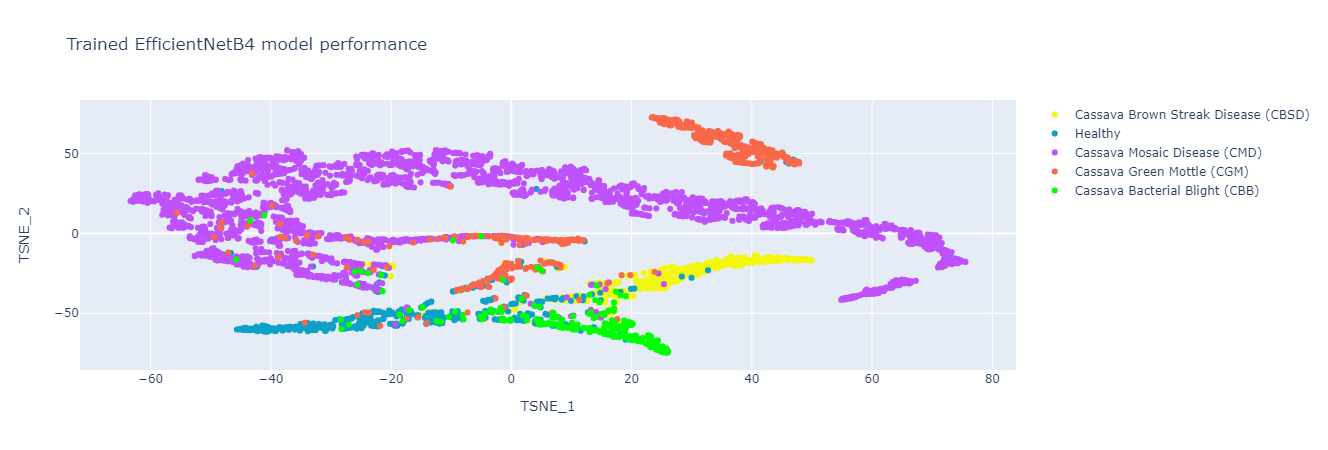

In [24]:
import plotly.graph_objects as go
fig = go.Figure()
colors = ['rgb(243, 247, 15)','rgb(13, 160, 200)','rgb(190, 81, 249)','rgb(248, 104, 73)','rgb(0,255,0)']
for idx,dn in enumerate(tsne_tr['disease_name'].unique()):
    df = tsne_tr[tsne_tr['disease_name'] == dn]
    fig.add_trace(go.Scatter(x=df['t_sne1'],y=df['t_sne2'],mode='markers',marker_color = colors[idx],name=dn))
fig.update_layout(title='Trained EfficientNetB4 model performance')
fig.update_xaxes(title_text="TSNE_1")
fig.update_yaxes(title_text="TSNE_2")
fig.show()